In [1]:
import geopandas as gpd
import pandas as pd
import os
import matplotlib.pyplot as plt

# --- Configuration ---
# Point this to the folder containing .shp, .shx, .dbf, .prj
SHAPEFILE_PATH = "./taxi_zones/taxi_zones.shp"
OUTPUT_CSV = "taxi_zones_detailed.csv"


In [2]:
def process_shapefile():
    print("🗺️  Orion: Initializing Duplicate-Proof Shapefile Processor...")

    if not os.path.exists(SHAPEFILE_PATH):
        print(f"❌ Error: Shapefile not found at {SHAPEFILE_PATH}")
        return

    try:
        gdf = gpd.read_file(SHAPEFILE_PATH)
        print(f"✅ Loaded Shapefile. Rows: {len(gdf)}")
        print(f"   Raw Columns: {list(gdf.columns)}")
    except Exception as e:
        print(f"❌ Failed to load shapefile: {e}")
        return

    # --- 1. Smart Renaming Strategy ---
    # We iterate through columns and decide what to keep.
    # We want to avoid creating duplicate 'LocationID' columns.

    current_cols = list(gdf.columns)
    rename_map = {}

    # Helper to find column case-insensitively
    def find_col(target_name, col_list):
        for c in col_list:
            if c.lower() == target_name.lower():
                return c
        return None

    # A. Handle ID
    loc_id = find_col("LocationID", current_cols)
    obj_id = find_col("OBJECTID", current_cols)

    if loc_id:
        # We have the official ID. Use it.
        rename_map[loc_id] = "LocationID"
        # If we also have OBJECTID, we drop it later or ignore it to prevent collision
    elif obj_id:
        # We only have OBJECTID, so we promote it.
        rename_map[obj_id] = "LocationID"
    else:
        print("❌ Critical: No 'LocationID' or 'OBJECTID' found.")
        return

    # B. Handle Borough
    boro = find_col("borough", current_cols)
    if boro:
        rename_map[boro] = "Borough"

    # C. Handle Zone
    zone = find_col("zone", current_cols)
    if zone:
        rename_map[zone] = "Zone"

    # D. Handle Service Zone
    svc = find_col("service_zone", current_cols)
    if svc:
        rename_map[svc] = "service_zone"

    print(f"🔄 Renaming Map: {rename_map}")
    gdf = gdf.rename(columns=rename_map)

    # --- 2. Drop Duplicates (Safety Valve) ---
    # If for some reason we still have duplicates, this removes them.
    gdf = gdf.loc[:, ~gdf.columns.duplicated()]

    # --- 3. Reprojection ---
    if gdf.crs != "EPSG:4326":
        print("🔄 Reprojecting to EPSG:4326 (Lat/Lon)...")
        gdf = gdf.to_crs("EPSG:4326")

    # --- 4. Centroid Calculation ---
    print("📍 Calculating Zone Centroids...")
    gdf["centroid"] = gdf.geometry.centroid
    gdf["centroid_lat"] = gdf["centroid"].y
    gdf["centroid_lon"] = gdf["centroid"].x

    # --- 5. Extract & Save ---
    # Fill missing Service Zone if needed
    if "service_zone" not in gdf.columns:
        gdf["service_zone"] = "Unknown"

    # Select final columns safely
    final_cols = ["LocationID", "Borough", "Zone", "service_zone", "centroid_lat", "centroid_lon"]
    output_df = pd.DataFrame(gdf[final_cols])

    # Sort
    output_df = output_df.sort_values("LocationID")

    print("\n🔍 Validation Sample:")
    print(output_df.head())

    output_df.to_csv(OUTPUT_CSV, index=False)
    print(f"\n💾 Saved Detailed Zone Map to: {os.path.abspath(OUTPUT_CSV)}")

    # Optional: Quick Plot to verify it looks like NYC
    gdf.plot(column="Borough", legend=True)
    plt.show()


🗺️  Orion: Initializing Duplicate-Proof Shapefile Processor...
✅ Loaded Shapefile. Rows: 263
   Raw Columns: ['OBJECTID', 'Shape_Leng', 'Shape_Area', 'zone', 'LocationID', 'borough', 'geometry']
🔄 Renaming Map: {'LocationID': 'LocationID', 'borough': 'Borough', 'zone': 'Zone'}
🔄 Reprojecting to EPSG:4326 (Lat/Lon)...
📍 Calculating Zone Centroids...

🔍 Validation Sample:
   LocationID        Borough                     Zone service_zone  \
0           1            EWR           Newark Airport      Unknown   
1           2         Queens              Jamaica Bay      Unknown   
2           3          Bronx  Allerton/Pelham Gardens      Unknown   
3           4      Manhattan            Alphabet City      Unknown   
4           5  Staten Island            Arden Heights      Unknown   

   centroid_lat  centroid_lon  
0     40.691831    -74.174000  
1     40.616745    -73.831299  
2     40.864474    -73.847422  
3     40.723752    -73.976968  
4     40.552659    -74.188484  

💾 Saved Detai

C:\Users\yopro\AppData\Local\Temp\ipykernel_24860\412015407.py:74: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["centroid"] = gdf.geometry.centroid


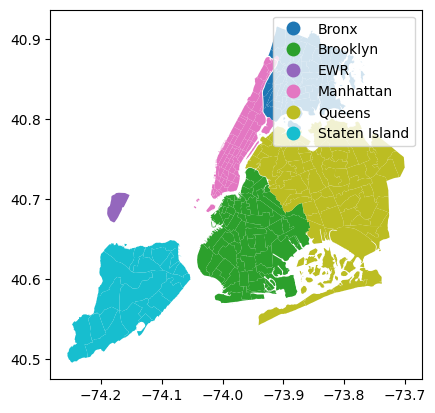

In [3]:
process_shapefile()